# Reading data

In [245]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
plt.close("all")

In [246]:
#Ref: https://medium.com/analytics-vidhya/tinder-data-54ba494e0a59
f = open('Data/myData/data.json', 'r', encoding="utf8")
data = json.load(f)["Usage"]

df = pd.DataFrame.from_dict(data)
print(df)
df.describe()

            app_opens  swipes_likes  swipes_passes  superlikes  matches  \
2022-11-19         33             4            394           0        1   
2022-11-20         15            14            714           0        0   
2022-11-21          7             2             36           0        0   
2022-11-22          4             2             51           0        1   
2022-11-23          5             1             23           0        2   
...               ...           ...            ...         ...      ...   
2023-09-18          5             1             26           0        0   
2023-09-19         12             0             52           0        0   
2023-09-20          4             0              0           0        0   
2023-09-21         10             1             57           0        0   
2023-09-22          8             2             38           0        1   

            messages_sent  messages_received advertising_id idfa  
2022-11-19              2       

,app_opens,swipes_likes,swipes_passes,superlikes,matches,messages_sent,messages_received
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,7.354167,1.833333,80.677083,0.010417,0.552083,1.786458,1.822917
std,6.467768,2.862162,137.262503,0.101795,0.829682,5.634711,6.507337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.000000,38.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,82.250000,0.000000,1.000000,2.000000,1.000000
max,40.000000,15.000000,1152.000000,1.000000,5.000000,64.000000,79.000000


# Wrangling

In [247]:
df.index.name = "Date"
df = df.sort_values(["swipes_passes"], ascending = False)
df = df.drop(["superlikes", "advertising_id", "idfa"], axis = 1)

df.index = pd.to_datetime(df.index)
df = df.sort_values(by='Date')

df["swipes_likes_no_match"] = df["swipes_likes"] - df["matches"]
df["matches_cumsum"] = df["matches"].cumsum()

#WEEKLY STATS
df_passes_weekly = df.resample("W-MON").sum()

# df_passes_weekly = df_passes_weekly.drop("matches_cumsum")
df_passes_weekly["matches_cumsum"] = df_passes_weekly["matches"].cumsum()

df_passes_weekly["matches_like_pct"] = 100*df_passes_weekly["matches"] / df_passes_weekly["swipes_likes"] 
df_passes_weekly.fillna(0, inplace=True)
df_passes_weekly = df_passes_weekly.replace([np.inf, -np.inf], 0)


#MONTHLY STATS
df_passes_matches_monthly_scaled = df.resample("MS").sum()

# df_passes_matches_monthly_scaled = df_passes_matches_monthly_scaled.drop("matches_cumsum")
df_passes_matches_monthly_scaled["matches_cumsum"] = df_passes_matches_monthly_scaled["matches"].cumsum()

nb_passes_matches = (df_passes_matches_monthly_scaled["swipes_likes"]  + df_passes_matches_monthly_scaled["swipes_passes"] )

df_passes_matches_monthly_scaled["matches_like_pct"] = 100*df_passes_matches_monthly_scaled["matches"] / df_passes_matches_monthly_scaled["swipes_likes"] 
df_passes_matches_monthly_scaled["swipes_passes"] = 100*df_passes_matches_monthly_scaled["swipes_passes"] / nb_passes_matches
df_passes_matches_monthly_scaled["swipes_likes_no_match"] = 100*df_passes_matches_monthly_scaled["swipes_likes_no_match"] / nb_passes_matches
df_passes_matches_monthly_scaled["matches"] = 100*df_passes_matches_monthly_scaled["matches"] / nb_passes_matches
df_passes_matches_monthly_scaled.fillna(0, inplace=True)
df_passes_matches_monthly_scaled = df_passes_matches_monthly_scaled.replace([np.inf, -np.inf], 0)

# df_likes_matches_monthly_scaled = df_passes_weekly.resample("MS").sum()

# nb_likes_matches = (df_likes_matches_monthly_scaled["matches"] + df_likes_matches_monthly_scaled["swipes_likes"])

# df_likes_matches_monthly_scaled["swipes_likes"] = 100*df_likes_matches_monthly_scaled["swipes_likes"] / nb_likes_matches
# df_likes_matches_monthly_scaled["matches"] = 100*df_likes_matches_monthly_scaled["matches"] / nb_likes_matches


# df.head(100)
# df_passes_weekly.head()
# df_passes_matches_monthly_scaled.head()
# df = df.describe()

# Visualizaiton

array([[<AxesSubplot:xlabel='app_opens', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='app_opens'>,
        <AxesSubplot:xlabel='matches', ylabel='app_opens'>,
        <AxesSubplot:xlabel='messages_sent', ylabel='app_opens'>,
        <AxesSubplot:xlabel='messages_received', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_likes_no_match', ylabel='app_opens'>,
        <AxesSubplot:xlabel='matches_cumsum', ylabel='app_opens'>],
       [<AxesSubplot:xlabel='app_opens', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='matches', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='messages_sent', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='messages_received', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_likes_no_match', ylabel='s

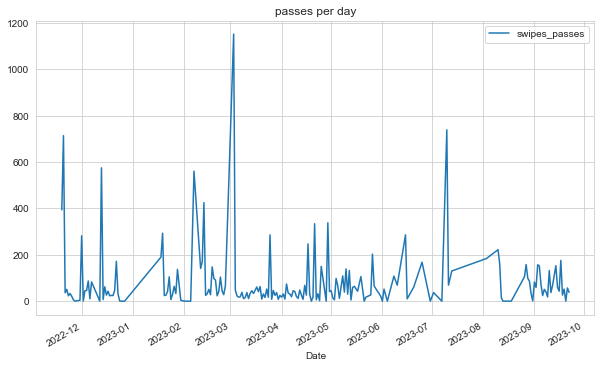

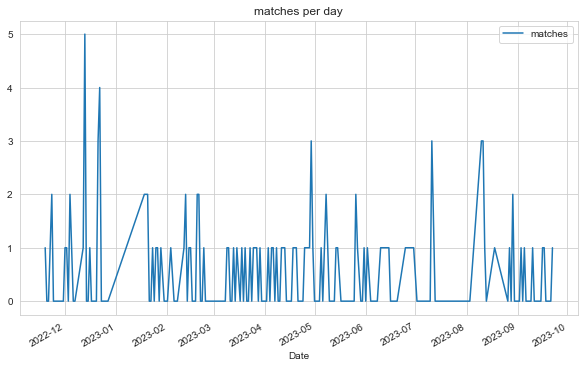

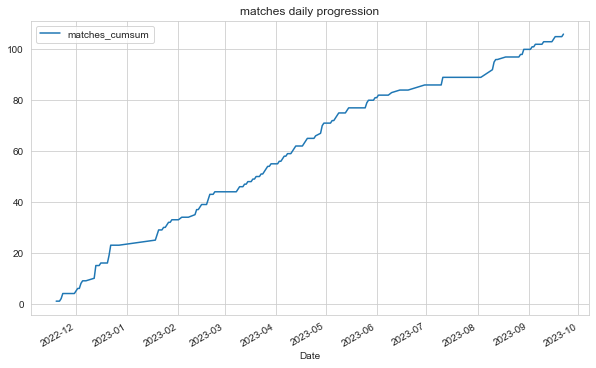

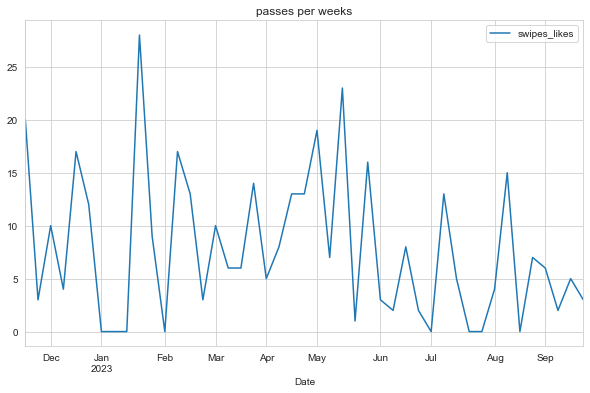

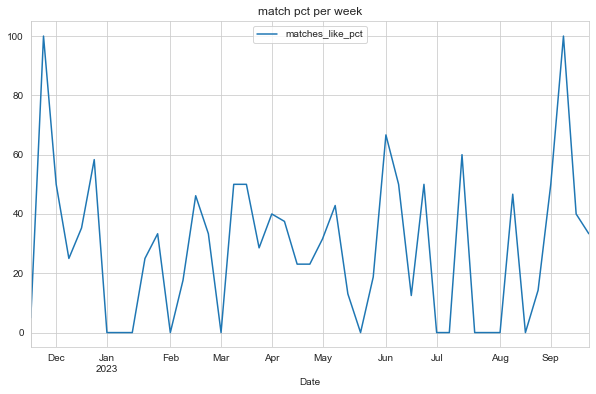

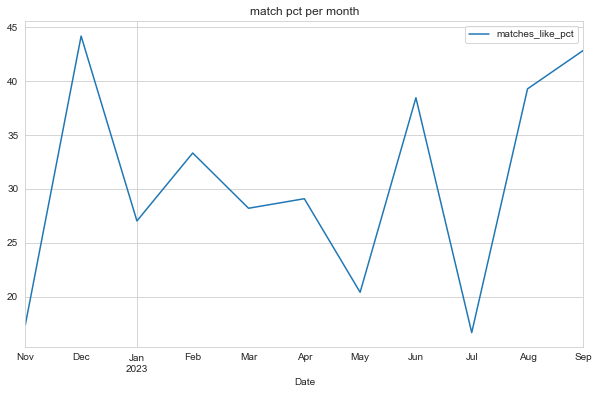

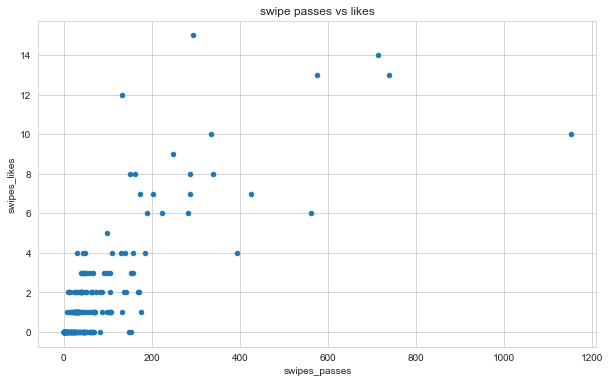

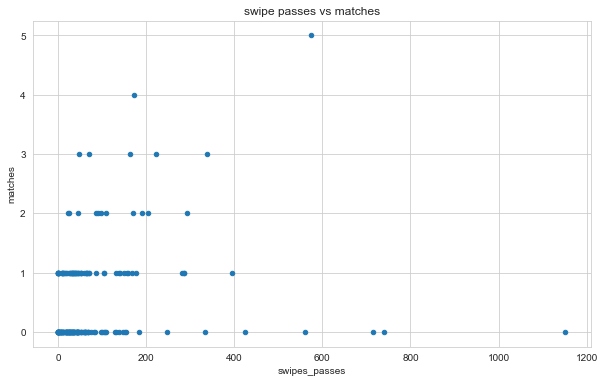

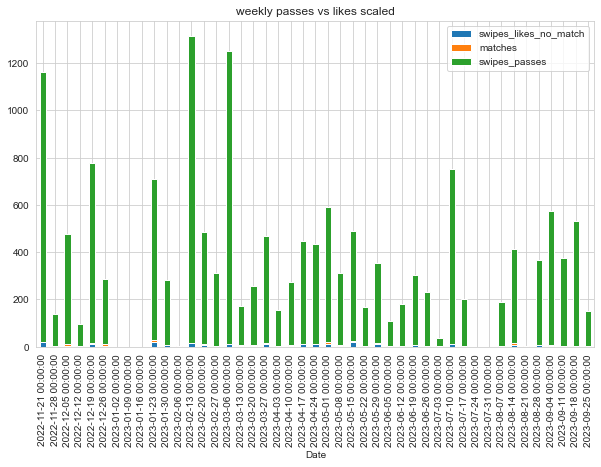

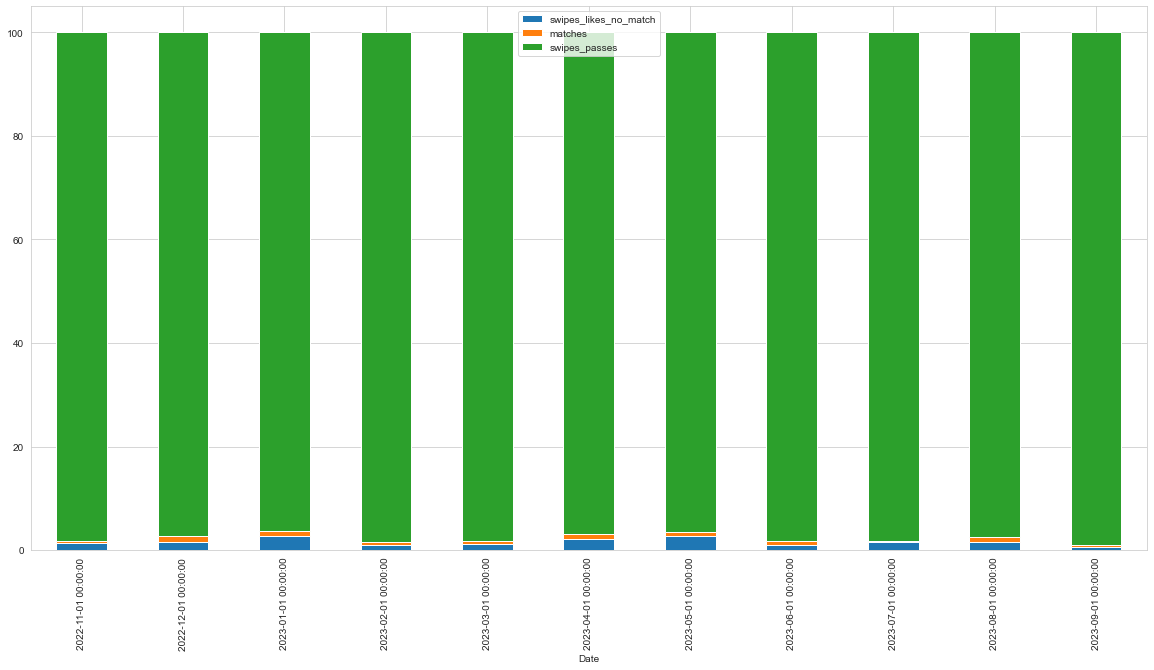

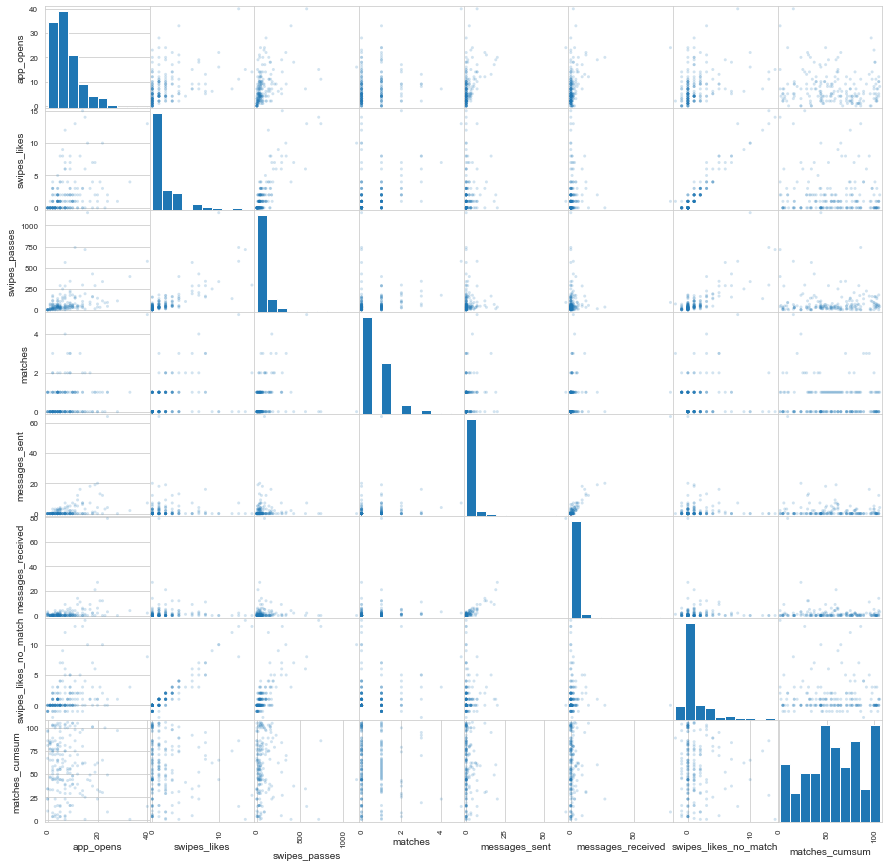

In [250]:
#passes per day
df.plot(y = "swipes_passes", figsize=(10, 6), title = "passes per day")
#matches per day
df.plot(y = "matches", figsize=(10, 6), title = "matches per day") #bad
#matches daily progression
df.plot(y = "matches_cumsum", figsize=(10, 6), title = "matches daily progression") 

#passes per weeks
df_passes_weekly.plot(y = "swipes_likes", figsize=(10, 6), title = "passes per weeks")

#match pct weeks
df_passes_weekly.plot(y = "matches_like_pct", figsize=(10, 6), title = "match pct per week")

#match pct month
df_passes_matches_monthly_scaled.plot(y = "matches_like_pct", figsize=(10, 6), title = "match pct per month")

#swipe passes vs swipe likes
df.plot.scatter(x = "swipes_passes", y = "swipes_likes", figsize=(10, 6), title = "swipe passes vs likes") #bad
#swipe passes vs matches
df.plot.scatter(x = "swipes_passes", y = "matches", figsize=(10, 6), title = "swipe passes vs matches") 

#weekly passes + matches bar
df_passes_weekly.plot.bar(y = ["swipes_likes_no_match", "matches", "swipes_passes"], stacked = True, figsize=(10, 6), title = "weekly passes vs likes scaled")

# #monthly likes + matches bar scaled to 100 AKA success rate
# df_likes_matches_monthly_scaled.plot.bar(y = ["matches", "swipes_likes"], stacked = True, figsize=(20,10))

#monthly passes + matches bar scaled to 100
df_passes_matches_monthly_scaled.plot.bar(y = ["swipes_likes_no_match", "matches", "swipes_passes"], stacked = True, figsize=(20,10))
pd.plotting.scatter_matrix(df, alpha = .2, figsize=(15, 15))




"""
TO ADD NEXT:
- cumsum for total swipes to vis daily progression
- work with app opens 
- compare messages sent vs received
- finalize what I want to viz -> MAX 4 viz
- switch from df.plot -> seaborn
- do the river flow chart?
"""